In [11]:
%matplotlib inline

In [12]:
from __future__ import print_function
import numpy as np
import scipy
import matplotlib.pyplot as plt

import librosa
import librosa.display
from sklearn.preprocessing import binarize

sorted from most frequent: [ 2  0  5 10  7], according to weights [ 1.          0.763021    0.68750003  0.68489586  0.45572916]
sorted in ascending order from pc-0: [ 0  2  5  7 10]
[ 2  5  7 10  0]


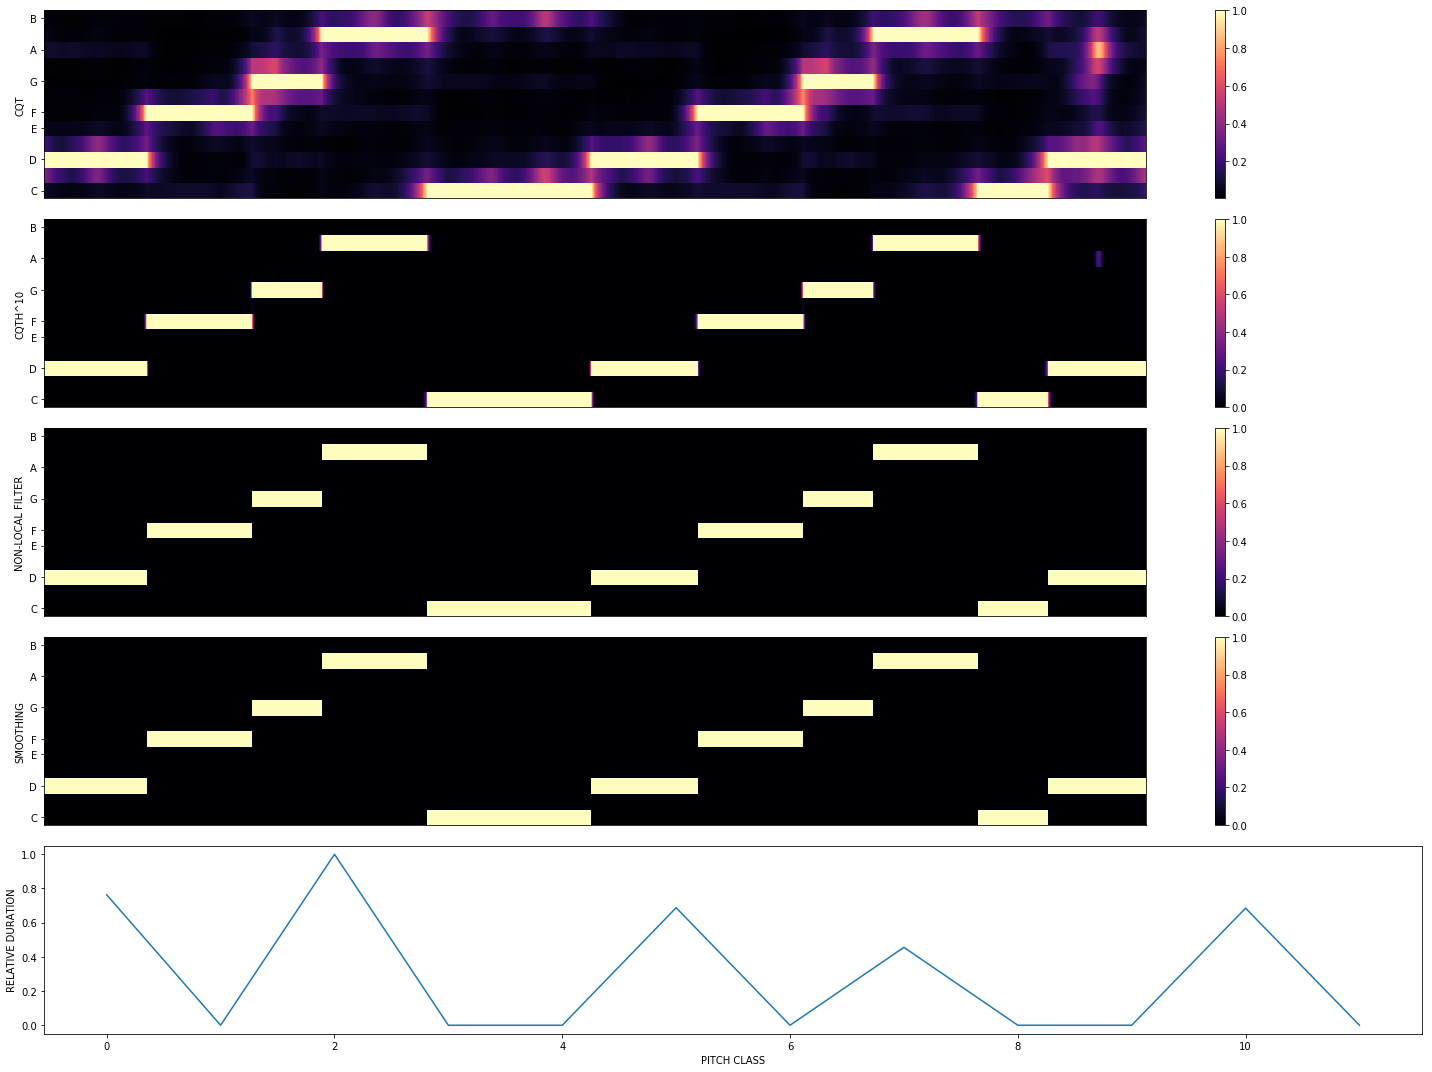

In [17]:
f = '/Users/angelosx/Insync/midi/HOUSE-BASS/_ANOTADAS/RankinAudio-DeepAnalogueHouse/audio/DAH_120bpm_Bassloop_Dm_4.wav'

y, sr = librosa.load(f, sr=22050, duration=16) # 16 s. corresponds to 8 bars at 120 bpm's.

cqth = librosa.feature.chroma_cqt(y=librosa.effects.harmonic(y=y, margin=8), 
                                  sr=sr,
                                  hop_length=128,
                                  norm=np.inf,
                                  threshold=None,
                                  fmin=librosa.note_to_hz('A0'),
                                  n_octaves=6,
                                  bins_per_octave=36,
                                  n_chroma=12,
                                  cqt_mode='full')

cqthe = np.power(cqth,10)

# to remove passing notes and other possible short artifacts
cqthef = np.minimum(cqthe, librosa.decompose.nn_filter(cqthe, aggregate=np.median, metric='cosine'))

# Local discontinuities and transients can be suppressed by using a horizontal median filter:
cqthefs = scipy.ndimage.median_filter(cqthef, size=(1, 9))

# we could binarize it... or not.
# cqthef = binarize(cqthe, 0.2)


# aggregation of vectors
# ======================
aggregate_all = np.sum(cqthefs, axis=1)
scale_all = np.divide(aggregate_all, np.max(aggregate_all))


# manipulations on the aggregated vector:
# =======================================

# sub-arrays with only NON-ZERO elements (in descending order of duration)
weights_sorted = np.flip(np.sort(scale_all[scale_all > 0.1]), axis=0)
pcs_by_weigth = (np.flip(np.argsort(scale_all), axis=0))[:weights_sorted.size]
pcs_ascending = np.sort(pcs_by_weigth)
pcs_from_longest = np.roll(pcs_ascending, -1 * np.where(pcs_ascending==pcs_by_weigth[0])[0][0])

print('sorted from most frequent: {}, according to weights {}'.format(pcs_by_weigth, weights_sorted))
print('sorted in ascending order from pc-0: {}'.format(pcs_ascending))
print(pcs_from_longest)


# create plots
# ============
plt.figure(figsize=(20,15))
plt.subplot(5,1,1)
librosa.display.specshow(cqth, y_axis='chroma')
plt.colorbar()
plt.ylabel('CQT')

plt.subplot(5,1,2)
librosa.display.specshow(cqthe, y_axis='chroma')
plt.colorbar()
plt.ylabel('CQTH^10')
plt.tight_layout()

plt.subplot(5,1,3)
librosa.display.specshow(cqthef, y_axis='chroma')
plt.colorbar()
plt.ylabel('NON-LOCAL FILTER')
plt.tight_layout()

plt.subplot(5,1,4)
librosa.display.specshow(cqthefs, y_axis='chroma')
plt.colorbar()
plt.ylabel('SMOOTHING')
plt.tight_layout()

plt.subplot(5,1,5)
ax = plt.gca()
ax.plot(scale_all)
ax.set_xlabel('PITCH CLASS')
ax.set_ylabel('RELATIVE DURATION')
plt.tight_layout()

In [18]:
# now lets estimate the tempo of the track:
tempo = librosa.beat.tempo(onset_envelope=librosa.onset.onset_strength(y, sr=sr), sr=sr)
print(tempo)

[ 80.74951172]
